In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from sklearn import datasets
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from pylab import rcParams
rcParams['figure.figsize'] = 8, 6
rcParams['figure.dpi'] = 300

In [ ]:
def checkerboard(height, width, r=False):
    """
    Takes in the dimensions of the checkerboard mask to be produced.
    Will output a 2D tf tensor containing a checkerboard pattern of 1s and 0s.
    """
    checkerboard = [[(i + j) % 2 for j in range(width)] for i in range(height)]
    return tf.convert_to_tensor(checkerboard, dtype='float32')

In [ ]:
def KLdivergence(x, y):
  """Compute the Kullback-Leibler divergence between two multivariate samples.
  Parameters
  ----------
  x : 2D array (n,d)
    Samples from distribution P, which typically represents the true
    distribution.
  y : 2D array (m,d)
    Samples from distribution Q, which typically represents the approximate
    distribution.
  Returns
  -------
  out : float
    The estimated Kullback-Leibler divergence D(P||Q).
  References
  ----------
  Pérez-Cruz, F. Kullback-Leibler divergence estimation of
continuous distributions IEEE International Symposium on Information
Theory, 2008.
  """
  from scipy.spatial import cKDTree as KDTree

  # Check the dimensions are consistent
  x = np.atleast_2d(x)
  y = np.atleast_2d(y)

  n,d = x.shape
  m,dy = y.shape

  assert(d == dy)


  # Build a KD tree representation of the samples and find the nearest neighbour
  # of each point in x.
  xtree = KDTree(x)
  ytree = KDTree(y)

  # Get the first two nearest neighbours for x, since the closest one is the
  # sample itself.
  r = xtree.query(x, k=2, eps=.01, p=2)[0][:,1]
  s = ytree.query(x, k=1, eps=.01, p=2)[0]

  # There is a mistake in the paper. In Eq. 14, the right side misses a negative sign
  # on the first term of the right hand side.
  return -np.log(r/s).sum() * d / n + np.log(m / (n - 1.))

In [ ]:
class RNVP(tf.keras.Model):
    def __init__(self, depth, height, prior_dim, hidden_size):
        super(RNVP, self).__init__()

        """
        Takes in the depth of each component network in the Model (depth) as well as the dimension of the density we're estimating (prior_dim).
        The structure of the Model has four main components, the mask, the prior, the t-network and the s-network.
        In init we construct each of these according to the specifications described by height, depth and prior_dim
        
        Inputs:
          depth: number of layers in each network of s and t
          height: number of transformations (ie, height of mask/ number of networks in s and t)
          prior_dim: dimension size of input data points 
          hidden_size: number of nodes in each of the hidden layers
        """
        self.prior_dim = prior_dim
        ## Construct prior
        ## We assume for simplicity the prior is a MVN of the same dimension as the input data
        self.prior = tfp.distributions.MultivariateNormalTriL(loc=tf.zeros(prior_dim), scale_tril=tf.eye(prior_dim))
        ## Construct mask
        self.height = height 
        self.mask = checkerboard(self.height,prior_dim)
        ## Initialize t and s network lists
        ## The number of networks in the list should be the same as the number of rows in mask
        ## Each network should have number of layers = depth, the last layer in each s network should have tanh activation
        self.t = []
        self.s = []
        for i in range (self.height):
          self.t.append(Sequential())
          self.s.append(Sequential())
        self.hidden_size = hidden_size
        ## Fill each network in both network lists
        for j in range(self.height):
            for i in range(depth-1):
                self.t[j].add(Dense(
                    self.hidden_size,
                    activation= tf.keras.layers.LeakyReLU(alpha=0.01),
                    kernel_initializer= 'uniform',
                    bias_initializer= 'uniform'))
                self.s[j].add(Dense(
                    self.hidden_size,
                    activation= tf.keras.layers.LeakyReLU(alpha=0.01),
                    kernel_initializer= 'uniform',
                    bias_initializer= 'uniform'))
            self.t[j].add(Dense(
                prior_dim,
                kernel_initializer= 'uniform',
                bias_initializer= 'uniform'))
            self.s[j].add(Dense(
                prior_dim,
                activation='tanh',
                kernel_initializer= 'uniform',
                bias_initializer= 'uniform'))


    def call(self, x):
        """
        When the layers have been fully learned, this call will transform data from an arbitrary
        distribution to data from a multivariate normal distribution in an invertible way 

        Inputs:
            x: A sample distribution of size (num_samples x prior_dim)
        Returns:
            output_dist: forward transform of x, what the original distribution looks like in the latent space (prior distribution)
            sldj: the log determinant of the Jacobian for the s network layers
        """
        ## Initialize our output_dist as our input_dist x, we will iteratively update it until it looks normal
        output_dist = x
        num_samples = x.shape[0]
        sldj = tf.zeros([num_samples])
        ## Loop through each row in the mask and each network in t and s 
        for i in range(self.height):
            ## Mask and reverse mask will each be of shape (prior_dim)
            mask = self.mask[i]
            reverse_mask = 1 - mask
            ## The variables s and t in the loop will be networks with number of layers = depth
            s = self.s[i]
            t = self.t[i]
            ## First apply the forward mask to output_dist
            ## output_dist_masked will have the same shape as output_dist (num_samples x prior_dim)
            output_dist_masked = mask * output_dist
            ## Pass this through s and t and subsequently apply reverse mask
            ## s_out and t_out will be of size (num_samples x prior_dim)
            s_out = s(output_dist_masked)* reverse_mask
            t_out = t(output_dist_masked)* reverse_mask
            ## Update output_dist via the transformation described in equation (8) of this paper https://arxiv.org/pdf/1605.08803.pdf
            ## We add the un-updated output_dist_masked to the updated output_dist multiplied by the reverse mask 
            updated_dist = (output_dist-t_out) * tf.math.exp(-1 * s_out)
            output_dist = output_dist_masked + reverse_mask * updated_dist
            ## We also update the log of the determinant of the Jacobian at each step of the transformation according
            ## to equation (6) from the same paper. Note we are subtracting away instead of adding because we are looking at the reverse transformation
            ## of the one described in the paper. We still want to maximize this sldj value even though it's negative
            sldj -= tf.math.reduce_sum(s_out, axis=1)

        return output_dist, sldj


    def loss_function(self, output_dist, sldj):
        """
        By the change of variable theory, computing the density on a point x is accomplished by
        computing the density of its image f(x) and multiplying by the associated Jacobian determinant
        of the transformation (3) | we can thus define our negative log likelihood (which we hope to minimize)
        as the average of our sldj output subtracted out from the negative prior log probability of the output distribution

        Inputs:
            output_dist: latent space distribution 
            sldj: negative log of the determinant of the jacobian of the transformation 
        Returns:
            loss: average negative log likelihood as described above
        """
        z = output_dist
        ## Negative prior log probability of the output distribution
        # prior_ll = self.prior.log_prob(output_dist)
        prior_ll = -.5 * (tf.math.square(z) + np.log(2*np.pi))
        prior_ll = tf.reduce_sum(prior_ll,-1)
        ## Subtract out log determinant of jacobian 
        ll = prior_ll + sldj
        ## Average and return
        nll = -tf.reduce_mean(ll)

        return tf.reduce_mean(nll)

  
    def sample (self, num_samples):
      """
        This function performs the inverse operation of call, so that once the transformation layers
        have been fully learned you will be able to generate num_samples data points from the prior 
        (via simple sampling) and then transform those points to the desired distribution we've learned
        This offers a quick and efficient way of sampling from arbitrarily complex distributions so long as they've been
        learned by the model.  

        Inputs:
            num_samples: the number of sample points you want to generate
        Returns:
            input_dist: a sampled distribution of points from the input space of size num_samples
        """
      ## Randomly sample from prior
      input_dist = self.prior.sample([num_samples])
      ## Run inverse transformation (ie do the steps in call but backwards)
      for i in reversed(range(self.height)):
        ## Mask and reverse mask will each be of shape (prior_dim)
        mask = self.mask[i]
        reverse_mask = 1 - mask
        ## The variables s and t in the loop will be networks with number of layers = depth
        s = self.s[i]
        t = self.t[i]
        ## First apply the forward mask to input_dist
        input_dist_masked = mask * input_dist
        ## Pass this through s and t and subsequently apply reverse mask
        s_out = s(input_dist_masked)* reverse_mask
        t_out = t(input_dist_masked)* reverse_mask
        ## Update input_dist via the transformation described in equation (7) of this paper https://arxiv.org/pdf/1605.08803.pdf
        input_dist = input_dist_masked + reverse_mask * (t_out + input_dist * tf.math.exp(s_out))

      return input_dist

In [ ]:
flow = RNVP(depth = 3, height = 6, prior_dim = 2, hidden_size = 256)

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
for t in range(5001):   
    moons = datasets.make_moons(n_samples=100, noise=.05)[0].astype(np.float32)
    with tf.GradientTape() as tape:
      z, sldj = flow.call(tf.convert_to_tensor(moons))
      loss = flow.loss_function(z, sldj)
    gradients = tape.gradient(loss, flow.trainable_variables)
    optimizer.apply_gradients(zip(gradients, flow.trainable_variables))
    
    if t % 200 == 0:
        print('iter %s:' % t, 'loss = %.3f' % loss)

iter 0: loss = 2.501
iter 200: loss = 1.574
iter 400: loss = 0.947
iter 600: loss = 0.822
iter 800: loss = 0.624
iter 1000: loss = 0.633
iter 1200: loss = 0.509
iter 1400: loss = 0.718
iter 1600: loss = 0.596
iter 1800: loss = 0.495
iter 2000: loss = 0.511
iter 2200: loss = 0.473
iter 2400: loss = 0.568
iter 2600: loss = 0.543
iter 2800: loss = 0.542
iter 3000: loss = 0.503
iter 3200: loss = 0.607
iter 3400: loss = 0.455
iter 3600: loss = 0.585
iter 3800: loss = 0.572
iter 4000: loss = 0.567
iter 4200: loss = 0.436
iter 4400: loss = 0.427
iter 4600: loss = 0.404
iter 4800: loss = 0.558
iter 5000: loss = 0.482


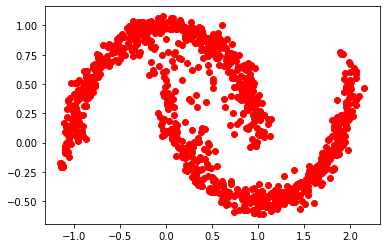

In [ ]:
'''
We can generate a sample from the canoncial gaussian distribution and compare it to the prior we create using our forward transfomation (call function)
We can similarly generate a sample from the canonical noisy-moon distribution and compare it to our sampling from our learned distribution (sample function)
'''
canonical_gaussian = flow.prior.sample(1000).numpy()
canonical_moons = datasets.make_moons(n_samples=1000, noise=.05)[0].astype(np.float32)
constructed_gaussian, _ = flow.call(tf.convert_to_tensor(canonical_moons))
constructed_moons = flow.sample(1000).numpy()

fig, axs = plt.subplots(2,2)
axs[0,0].scatter(canonical_gaussian[:,0],canonical_gaussian[:,1])
axs[0,0].set_title('Real Prior')
axs[0,1].scatter(constructed_moons[:,0],constructed_moons[:,1], c='r')
axs[0,1].set_title('Learned Moons')
axs[1,0].scatter(constructed_gaussian[:,0],constructed_gaussian[:,1],c='r')
axs[1,0].set_title('Learned Prior')
axs[1,1].scatter(canonical_moons[:,0],canonical_moons[:,1])
axs[1,1].set_title('Real Moons')
plt.show()


In [ ]:
divergences = 0
for x in range(100):
  y = flow.sample(10000)
  x = datasets.make_moons(n_samples=10000, noise=0.5)[0].astype(np.float32)
  divergences += KLdivergence(x,y)
print(divergences / 100)

2.8469398167185567


In [ ]:
generic_digits_flow = RNVP(depth = 8, height = 6, prior_dim = 784, hidden_size = 512)

In [ ]:
(train_images, _), (test_images, _) = tf.keras.datasets.mnist.load_data()
train_images = np.reshape(train_images, [train_images.shape[0], -1])
test_images = np.reshape(test_images, [test_images.shape[0],-1])
train_images = train_images / 255.0
test_images = test_images / 255.0

images = np.concatenate((train_images,test_images),axis=0)
images = tf.convert_to_tensor(images,dtype='float32')

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
for t in range(2001):   
    indices = np.random.choice(70000,50,replace=False)
    batch_of_digits = tf.gather(images,indices)
    with tf.GradientTape() as tape:
      z, sldj = generic_digits_flow.call(batch_of_digits)
      loss = generic_digits_flow.loss_function(z, sldj)
    gradients = tape.gradient(loss, generic_digits_flow.trainable_variables)
    optimizer.apply_gradients(zip(gradients, generic_digits_flow.trainable_variables))
    
    if t % 200 == 0:
        print('iter %s:' % t, 'loss = %.3f' % loss)

iter 0: loss = 764.883
iter 200: loss = -772.775
iter 400: loss = -921.858
iter 600: loss = -918.885
iter 800: loss = -973.541


In [ ]:
def show_images(images):
    images = np.reshape(images, [images.shape[0], -1])  # images reshape to (batch_size, D)
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]),cmap='gray')
    return

In [ ]:
x = tf.nn.sigmoid(generic_digits_flow.sample(16))
show_images(x)

NameError: ignored

In [ ]:
'''
Repeat above, but only train on a single type of digit 
'''
flow3 = RNVP(depth = 8, height = 6, prior_dim = 784, hidden_size = 512)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

digit = 7
(train_images, train_labels), (test_images,test_labels) = tf.keras.datasets.mnist.load_data()
train_images = np.reshape(train_images, [train_images.shape[0], -1])
train_images = train_images / 255.0
train_images = tf.convert_to_tensor([train_images[i,:] for i,element in enumerate(train_labels) if train_labels[i] == digit],dtype='float32')

test_images = np.reshape(test_images, [test_images.shape[0], -1])
test_images = test_images / 255.0
test_images = tf.convert_to_tensor([test_images[i,:] for i,element in enumerate(test_labels) if test_labels[i] == digit],dtype='float32')

digit_images = tf.concat((train_images,test_images),axis=0)
nums = tf.shape(digit_images)[0]

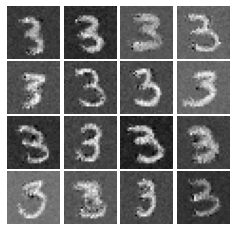

In [ ]:
x3 = tf.nn.sigmoid(flow3.sample(16))
show_images(x3)

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
for t in range(2601):   
    indices = np.random.choice(nums,100,replace=False)
    batch_of_digits = tf.gather(digit_images,indices)
    with tf.GradientTape() as tape:
      z, sldj = flow3.call(batch_of_digits)
      loss = flow3.loss_function(z, sldj)
    gradients = tape.gradient(loss, flow3.trainable_variables)
    optimizer.apply_gradients(zip(gradients, flow3.trainable_variables))
    
    if t % 200 == 0:
        print('iter %s:' % t, 'loss = %.3f' % loss)

iter 0: loss = 762.113
iter 200: loss = -1056.527
iter 400: loss = -1176.407
iter 600: loss = -1202.180
iter 800: loss = -1207.693
iter 1000: loss = -1248.526
iter 1200: loss = -1270.473
iter 1400: loss = -1287.522
iter 1600: loss = -1296.799
iter 1800: loss = -1308.677
iter 2000: loss = -1312.896
iter 2200: loss = -1328.295
iter 2400: loss = -1324.799
iter 2600: loss = -1340.365


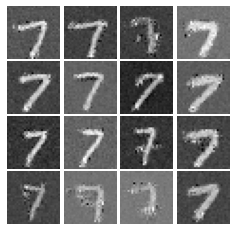

In [ ]:
x7 = tf.nn.sigmoid(flow3.sample(16))
show_images(x7) 

In [ ]:
divergences = 0
for x in range(10):
  y = flow3.sample(1000)
  x = digit_images[0:1000,:]
  divergences += KLdivergence(x,y)
print(divergences / 10)

1483.6037665818405


In [ ]:
'''
Repeat above, but only train on a single type of digit 
'''
fives = RNVP(depth = 8, height = 6, prior_dim = 784, hidden_size = 512)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

digit = 5
(train_images, train_labels), (test_images,test_labels) = tf.keras.datasets.mnist.load_data()
train_images = np.reshape(train_images, [train_images.shape[0], -1])
train_images = train_images / 255.0
train_images = tf.convert_to_tensor([train_images[i,:] for i,element in enumerate(train_labels) if train_labels[i] == digit],dtype='float32')

test_images = np.reshape(test_images, [test_images.shape[0], -1])
test_images = test_images / 255.0
test_images = tf.convert_to_tensor([test_images[i,:] for i,element in enumerate(test_labels) if test_labels[i] == digit],dtype='float32')

digit_images = tf.concat((train_images,test_images),axis=0)
nums = tf.shape(digit_images)[0]

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
for t in range(2001):   
    indices = np.random.choice(nums,100,replace=False)
    batch_of_digits = tf.gather(digit_images,indices)
    with tf.GradientTape() as tape:
      z, sldj = fives.call(batch_of_digits)
      loss = fives.loss_function(z, sldj)
    gradients = tape.gradient(loss, fives.trainable_variables)
    optimizer.apply_gradients(zip(gradients, fives.trainable_variables))
    
    if t % 200 == 0:
        print('iter %s:' % t, 'loss = %.3f' % loss)

iter 0: loss = 761.464
iter 200: loss = -945.127
iter 400: loss = -1018.557
iter 600: loss = -1068.153
iter 800: loss = -1084.863
iter 1000: loss = -1136.199
iter 1200: loss = -1133.220
iter 1400: loss = -1162.104
iter 1600: loss = -1184.185
iter 1800: loss = -1193.726
iter 2000: loss = -1195.182


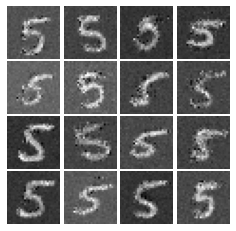

In [ ]:
fives_samples = tf.nn.sigmoid(fives.sample(16))
show_images(fives_samples) 